## Quantum Binary Classifier

using Cirq for quantum circuits (and running on quantum devices) and Pennylane for easy handling of hybrid machine learning.<br>
The dataset is based on non-convex random distributions using QRNG (quantum random number generator).

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import cirq
print("Cirq version", cirq.__version__)
import pennylane as qml
print("PennyLane version", qml.__version__)
import pennylane.numpy as pnp
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer, AdagradOptimizer

Cirq version 1.4.1
PennyLane version 0.41.0


### Quantum Random Number Generator

An important characteristic of qubits are their ability to represent a superposition of states. This can be used to generate "true" random numbers - unless the output of the quantum device is biased by noise.

A basic quantum random number generator is constructed by reading out $N$ qubits, each initialized to state $\ket{+}$ via a Hadamard gate (<tt>method=0</tt> (default)) or initialized to Bell pairs and reading only one state (0 or 1) if both qubits are in the same state (<tt>method=1</tt>).

In [2]:
## generate random numbers: outputs bitstring of length 'nbits' 
##                          unless 'normalized=True': then float between 0 and 1
##       method=0 (default): create random number via readout of |+> states (Hadamard)
##       method=1:           create random number via readout of Bell pairs and only keep bits if 
##                             both Bell-pair states are the same
##       verbose=False (default): no printout
##       verbose=True:            print circuit and generated random number

def qrng(nbits=1, normalized=False, method=0, verbose=False):
    if method == 1:
        # create a few more Bell pairs than required to neglect noisy results (|01> and |10>)
        qubits = cirq.LineQubit.range(int(nbits*1.1)*2+2)
        oplist = []
        for j in range(0, len(qubits)-1, 2):
            oplist.append( cirq.H(qubits[j]) )
            oplist.append( cirq.CNOT(qubits[j], qubits[j+1]) )
        oplist.append(cirq.measure(qubits, key="m"))
        
    else: 
        qubits = cirq.LineQubit.range(nbits)
        oplist = [ cirq.H(q) for q in qubits ]
        oplist.append( cirq.measure(qubits, key="m") )

    result = cirq.Simulator().run(cirq.Circuit(oplist), repetitions=1)
    sampled = list(result.histogram(key='m'))[0]
    if isinstance(sampled, int):
        sampled = bin(sampled)[2:].zfill(nbits)

    if method == 1:
        random_bits = ""
        #sampled = list(sampled)
        for j in range(0, len(sampled), 2):
            if sampled[j] == sampled[j+1]:
                random_bits += sampled[j]
        random_bits = random_bits[:nbits]
    else:
        random_bits = sampled
        
    if verbose:
        print("Circuit:")
        print(cirq.Circuit(oplist))
        print(f"Generated randoms:", sampled)  

    if normalized:
        max_random_bits = int('1'*nbits,2)
        return int(random_bits,2) / max_random_bits
    else:
        return random_bits
 
print("Random 4-bit pattern (from Bell pairs):", qrng(4,method=1,verbose=1))
print()
print("Random 32-bit pattern:", qrng(32))
print()
print("Normalized random number:", qrng(32, method=1,normalized=True))

Circuit:
0: ───H───@───M('m')───
          │   │
1: ───────X───M────────
              │
2: ───H───@───M────────
          │   │
3: ───────X───M────────
              │
4: ───H───@───M────────
          │   │
5: ───────X───M────────
              │
6: ───H───@───M────────
          │   │
7: ───────X───M────────
              │
8: ───H───@───M────────
          │   │
9: ───────X───M────────
Generated randoms: 11111100
Random 4-bit pattern (from Bell pairs): 1110

Random 32-bit pattern: 11101011011111111110000000101010

Normalized random number: 0.9616435291156274


### Generate 2D Non Convex Dataset

The goal is training and testing a binary classifier on a 2-dimensional dataset. The QNN shall learn the boundaries of a non-convex function on a plane and determine whether a a given point is on one or the other side of the curve.

Example: generate 5 non convex data points:
(array([[ 0.73635586,  0.66562109],
       [-0.12411217, -0.89705221],
       [-0.22658936, -0.03448154],
       [-0.85577503,  0.74771622],
       [ 0.89669752, -0.83330218]]), array([0, 0, 1, 1, 0]))

Generate training sample of 1000 data points ...


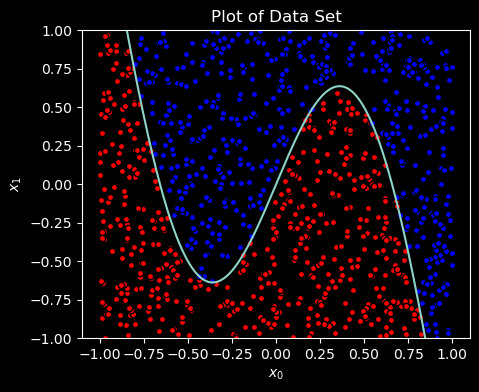

In [3]:
np.random.seed(431)  # only in case that "funct=None", then the boundary is: x[1] > x[0]

## define boundary function
def f_non_convex(s):
    return -2 * s + 1.5 * np.sin(np.pi * s)

## generate 2D samples (data) via Monte Carlo method with labels (above or below a boundary)
##   the boundary is defined by: x[1] > funct(x[0]); 
##       if the function is not provided, set boundary to x[1] > x[0]

def MC_sample(num_samples, funct=None):
    data, labels = [], []
    if funct is None:
        funct = (lambda s: s)
    for _ in range(num_samples):
        x = 2 * np.array([ qrng(32, normalized=True) for i in range(2) ]) - 1
        y = 1 if x[1] > funct(x[0]) else 0
        data.append(x)
        labels.append(y)
    return np.array(data), np.array(labels)

############################
## plot x=data, y=labels; plot boundary function if plot_function is not False 

def plot_data(x, y, plot_function=False, **kwargs):
    reds = y == 0
    blues = y == 1
    if "colors" in kwargs.keys() and isinstance(colors, (list,tuple)):
        color = kwargs["colors"].copy()
    else:
        color = ["red", "blue"]
    if "ax" in kwargs:
        ax = kwargs["ax"]
    else:
        if "figsize" not in kwargs.keys():
            kwargs["figsize"] = (5,4)
        fig, ax = plt.subplots(1, 1, figsize=kwargs["figsize"])
    ax.scatter(x[reds, 0], x[reds, 1], c=color[0], s=20, edgecolor="k")
    ax.scatter(x[blues, 0], x[blues, 1], c=color[1], s=20, edgecolor="k")
    ax.set_xlabel("$x_0$")
    ax.set_ylabel("$x_1$")

    x = np.linspace(-1, 1, 1000)
    if plot_function is None:
        plot_function = x
    elif isinstance(plot_function, bool) and plot_function == True:
        plot_function = x
    if not isinstance(plot_function, bool):
        plt.plot(x, plot_function(x))
    plt.ylim(-1, 1)
    if "title" not in kwargs.keys():
        kwargs["title"] = "Plot of Data Set"
    plt.title(kwargs["title"])
    
print("Example: generate 5 non convex data points:")
print(MC_sample(5))

## generate training data and plot them
print("\nGenerate training sample of 1000 data points ...")
X_train, Y_train = MC_sample(1000, f_non_convex)

plot_data(X_train, Y_train, plot_function=f_non_convex)

### Classification label representation

The first step is representing the classification labels as quantum state vectors and calculate the probability of these states (labels) for each input data using a density matrix representation. 

In [4]:
label_0 = [[1], [0]]
label_1 = [[0], [1]]
state_labels = [label_0, label_1]

def density_matrix(state):
    return state * np.conj(state).T

### Implementing Neuron Cost Function

In order to learn model weights we must create neurons within the network that have an associated weight and bias components, which are updated during the training process. Additionally, we must load the input data into qubits and apply the learned weights and biases to the neuron holding the information. 
<ul>
    <li>Loading data into qubits: Data are loaded into a qubit by applying general rotations on this qubit: $ROT(\phi,\theta,\omega) = R_z(\phi)\ R_y(\theta)\ R_z(\omega)$
    <li>Applying weights and biases to input: learning parameters are applied in the same way.
    Applying this multiple times (with different weights and biases) corresponds to adding additional neurons in the same layer of the neural network. To implement multiple hidden layers in the network we use more than one qubit that are entangled.</li>
    <li>Neuron activation: Once all the layers of the network have been applied to the input, the result is a point on the bloch sphere corresponding to the rotations applied to the input. 
        The classification state is obtained by calculating the measuring how close the output state is to the classification states (Blue = [1,0], Red = [0,1]).</li>
</ul>

In [5]:
dev = qml.device("default.qubit", wires=1)
# dev = qml.device("cirq.simulator", wires=1)
# dev = qml.device("qiskit.aer", wires=1)

@qml.qnode(dev)
def qcircuit(parameters, x=None, y=None):
    for param in parameters:
        qml.Rot(*x, wires=0)
        qml.Rot(*param, wires=0)
    return qml.expval(qml.Hermitian(y, wires=[0]))

## dummy circuit to get statevector
@qml.qnode(dev)
def qstate(parameters, x=None, y=None):
    for param in parameters:
        qml.Rot(*x, wires=0)
        qml.Rot(*param, wires=0)
    return qml.state()
    
def cost(parameters, x, y, state_labels=None):
    # Compute prediction for each input in the batch
    loss = 0.0
    density_matrix_labels = [density_matrix(s) for s in state_labels]
    for i in range(len(x)):
        f = qcircuit(parameters, x=x[i], y=density_matrix_labels[y[i]])
        loss = loss + (1 - f) ** 2
    return loss / len(x)

def fidelity(state1, state2):
    return np.abs(np.dot(np.conj(state1), state2))

#### Defining Learning Functions

Next the functions for training, testing, optimizing and analyzing our model over an input data set. 

In [6]:
def predicted_labels(states, state_labels=None):
    output_labels = [np.argmax([fidelity(s, label) for label in state_labels]) for s in states]
    return np.array(output_labels)

def test(parameters, x, y, state_labels=None):
    output_states = []
    density_matrix_labels = [density_matrix(s) for s in state_labels]
    for i in range(len(x)):
        expectation = qcircuit(params, x=x[i], y=density_matrix_labels[y[i]])
        output_states.append(qstate(params, x=x[i], y=density_matrix_labels[y[i]]))
    predicted = predicted_labels(output_states, state_labels)
    return predicted, output_states

def accuracy_score(y_true, y_prediction):
    score = y_true == y_prediction
    return score.sum() / len(y_true)

def iterate_minibatches(inputs, targets, batch_size):
    for start_idx in range(0, inputs.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield inputs[idxs], targets[idxs]

#### Initializing Model and Experimental Data



### Initializing model and experimental data

1. Prepare Training and Test Data
2. Initialize weights via Glorot model
3. Define training parameters

Glorot (Xavier) initialization generates optimal random weights for hidden nodes by accounting for network characteristics, i.e. number of input and output nodes. It initializes hidden-node weights to a random number between two boundaries. <br>
Glorot and Bengio proposed that for the signal to flow properly, the variance of the putputs of each layer
should be equal to the variance of the inputs. 
In addition, the gradients should maintain equal variance before and after flowing through a layer during backpropagation (this helps prevent the gradients from vanishing or exploding). <br>
To this end, we set the weights of each layer depending on the probability distribution and number of input neurons ($N_{in}$) and output neurons ($N_{out}$) for a given layer:

$\text{with} \quad N_{avg}=\frac{N_{in}+N_{out}}{2} : \quad r=\sigma^2 = \frac{1}{N_{avg}} \; \text{(range limit}\ [-r,r] \ \text{for normal distr.);}
\quad r = \sqrt{\frac{3}{N_{avg}}} \; \text{(for uniform distr.)}$

In [7]:
## Generate training and test data

num_training = 2000
num_test = 200

Xdata, y_train = MC_sample(num_training, funct=f_non_convex)
X_train = np.hstack((Xdata, np.zeros((Xdata.shape[0], 1))))

Xtest, y_test = MC_sample(num_test, funct=f_non_convex)
X_test = np.hstack((Xtest, np.zeros((Xtest.shape[0], 1))))

## Glorot initialization
num_layers = 8

def glorot(Nin, Nout, size=3):
  u_bound =  math.sqrt(6/(Nin+Nout))
  l_bound = -u_bound
  params = l_bound + (u_bound - l_bound) * np.array([
      [ qrng(nbits=32, normalized=True) for i in range(size)] for i in range(num_layers)
  ]) 
  return pnp.array(params)

In [12]:
## define model parameters and optimizer

learning_rate = 0.6
epochs = 5
batch_size = 32

opt = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)

params = glorot(2, 2)
print("Glorot initialized weights")
print(params)

predicted_train, states_train = test(params, X_train, y_train, state_labels)
accuracy_train = accuracy_score(y_train, predicted_train)

predicted_test, states_test = test(params, X_test, y_test, state_labels)
accuracy_test = accuracy_score(y_test, predicted_test)

initial_predictions = predicted_test

loss = cost(params, X_test, y_test, state_labels)

## train the model

print("Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
        0, loss, accuracy_train, accuracy_test))

for it in range(epochs):

    for Xbatch, ybatch in iterate_minibatches(X_train, y_train, batch_size=batch_size):
        params = opt.step(lambda v: cost(v, Xbatch, ybatch, state_labels), params)

    predicted_train, states_train = test(params, X_train, y_train, state_labels)
    accuracy_train = accuracy_score(y_train, predicted_train)
    loss = cost(params, X_train, y_train, state_labels)

    predicted_test, states_test = test(params, X_test, y_test, state_labels)
    accuracy_test = accuracy_score(y_test, predicted_test)
    res = [it + 1, loss, accuracy_train, accuracy_test]

    print("Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(*res))

Glorot initialized weights
[[-0.57955099 -1.00390689  1.0732621 ]
 [ 1.17973784 -0.02176073  0.7911191 ]
 [-0.59236325 -1.20696611  0.76580876]
 [ 1.04372848 -0.40290439 -0.51494488]
 [ 0.79592295  0.70240765  1.18222907]
 [ 1.0274879  -0.29763053  0.30472554]
 [-0.90609369  0.40657677  0.78684096]
 [-0.29107681  0.34098012  0.20214655]]
Epoch:  0 | Cost: 0.301091 | Train accuracy: 0.605000 | Test Accuracy: 0.535000
Epoch:  1 | Loss: 0.146087 | Train accuracy: 0.791500 | Test accuracy: 0.810000
Epoch:  2 | Loss: 0.190566 | Train accuracy: 0.710000 | Test accuracy: 0.735000
Epoch:  3 | Loss: 0.109709 | Train accuracy: 0.878500 | Test accuracy: 0.895000
Epoch:  4 | Loss: 0.112691 | Train accuracy: 0.834000 | Test accuracy: 0.875000
Epoch:  5 | Loss: 0.097448 | Train accuracy: 0.877500 | Test accuracy: 0.905000


#### Results

Cost: 0.097448 | Train accuracy 0.877500 | Test Accuracy : 0.905000


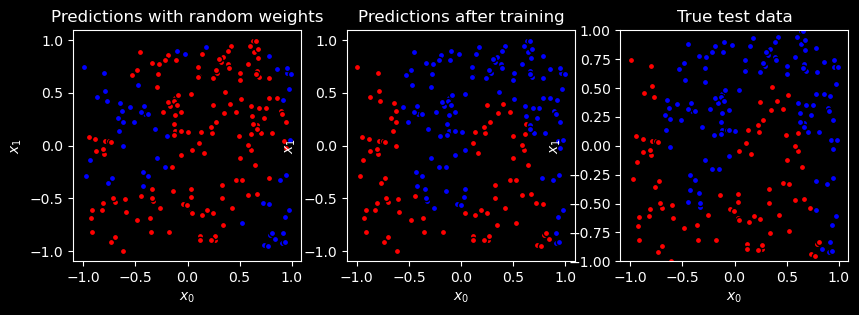

In [13]:
print(
    "Cost: {:3f} | Train accuracy {:3f} | Test Accuracy : {:3f}".format(
        loss, accuracy_train, accuracy_test
    )
)

fig, axes = plt.subplots(1, 3, figsize=(10, 3))
plot_data(X_test, initial_predictions, ax=axes[0])
plot_data(X_test, predicted_test, ax=axes[1])
plot_data(X_test, y_test, ax=axes[2])
axes[0].set_title("Predictions with random weights")
axes[1].set_title("Predictions after training")
axes[2].set_title("True test data")
plt.show()

0: ──Rot(-0.41,0.85,0.00)──Rot(-1.27,1.82,-2.15)──Rot(-0.41,0.85,0.00)──Rot(2.45,2.91,-0.46) ···

0: ··· ──Rot(-0.41,0.85,0.00)──Rot(-7.19,-0.32,3.88)──Rot(-0.41,0.85,0.00) ···

0: ··· ──Rot(-1.82,-0.27,0.45)──Rot(-0.41,0.85,0.00)──Rot(-2.32,-0.28,-3.34) ···

0: ··· ──Rot(-0.41,0.85,0.00)──Rot(-2.73,6.81,-2.03)──Rot(-0.41,0.85,0.00) ···

0: ··· ──Rot(-6.10,-0.03,-2.02)──Rot(-0.41,0.85,0.00)──Rot(-3.12,1.16,0.20)─┤  <𝓗(M0)>

M0 = 
[[1 0]
 [0 0]]


(<Figure size 1900x200 with 1 Axes>, <Axes: >)

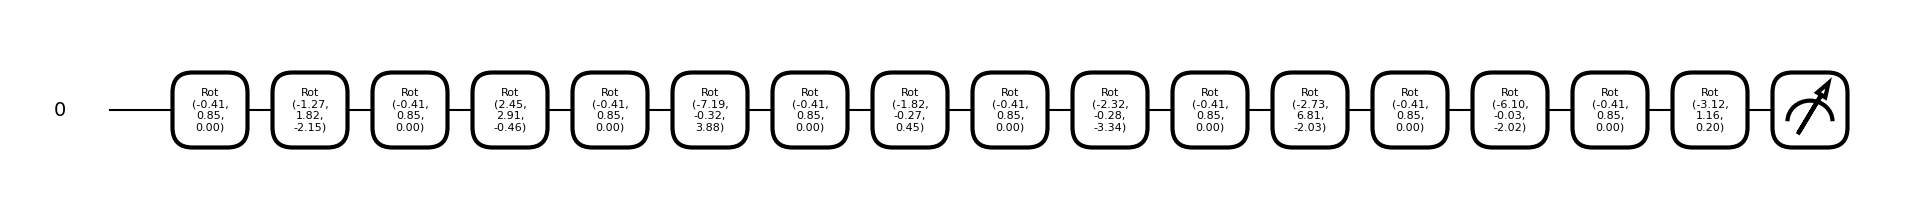

In [20]:
# Extract the first x and y values
x_first = X_train[0]
y_first = density_matrix(state_labels[Y_train[0]])

# Call the qcircuit function to draw the circuit
print(qml.draw(qcircuit)(params, x=x_first, y=y_first))
qml.draw_mpl(qcircuit, decimals=2)(params, x=x_first, y=y_first)